<a href="https://colab.research.google.com/github/zhiyangg/aps360/blob/main/APS360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("suuu")

suuu


In [1]:
import shutil
from pathlib import Path
data_path = Path("data/Dataset")

# Check if the directory exists
if data_path.exists() and data_path.is_dir():
    shutil.rmtree(data_path)
    print(f"Deleted the directory: {data_path}")
else:
    print(f"The directory {data_path} does not exist.")

The directory data/Dataset does not exist.


In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Dataset"

# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)


  # Download your dataset
  with open(data_path / "Dataset.zip", "wb") as f:
      print(f"Downloading data...")
      request = requests.get("https://github.com/raymanhuang/aps360data/raw/main/Dataset.zip")
      f.write(request.content)

  # Unzip your dataset
  with zipfile.ZipFile(data_path / "Dataset.zip", "r") as zip_ref:
      print(f"Unzipping data...")
      zip_ref.extractall(data_path)

Did not find data/Dataset directory, creating one...
Unzipping data...


In [3]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 3 directories and 0 images in 'data/Dataset'.
There are 3 directories and 0 images in 'data/Dataset/test'.
There are 0 directories and 459 images in 'data/Dataset/test/with_mask'.
There are 0 directories and 459 images in 'data/Dataset/test/mask_weared_incorrect'.
There are 0 directories and 459 images in 'data/Dataset/test/without_mask'.
There are 3 directories and 0 images in 'data/Dataset/train'.
There are 0 directories and 2076 images in 'data/Dataset/train/with_mask'.
There are 0 directories and 2076 images in 'data/Dataset/train/mask_weared_incorrect'.
There are 0 directories and 2076 images in 'data/Dataset/train/without_mask'.
There are 3 directories and 0 images in 'data/Dataset/val'.
There are 0 directories and 459 images in 'data/Dataset/val/with_mask'.
There are 0 directories and 459 images in 'data/Dataset/val/mask_weared_incorrect'.
There are 0 directories and 459 images in 'data/Dataset/val/without_mask'.


In [4]:
# Setup train, val, testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"
train_dir, test_dir, val_dir

(PosixPath('data/Dataset/train'),
 PosixPath('data/Dataset/test'),
 PosixPath('data/Dataset/val'))

In [5]:
print(image_path)

data/Dataset


In [6]:
image_path_list = list(image_path.glob("*/*/*.png"))

Visualizing raw data

Random image path: data/Dataset/train/with_mask/2874.png
Image class: with_mask
Image height: 128
Image width: 128


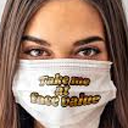

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

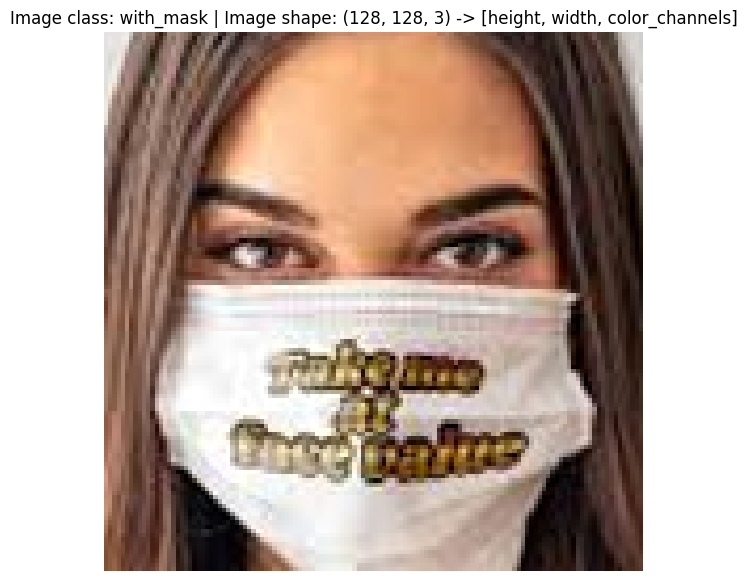

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Training baseline model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval()

    for imgs, labels in DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [38]:
def train_model(model, train_loader, valid_loader, lr=0.001, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()  # Set model to evaluation mode
        total_valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()
        valid_losses.append(total_valid_loss / len(valid_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Epoch vs. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


Epoch [1/10], Train Loss: 0.4651, Valid Loss: 0.2209
Epoch [2/10], Train Loss: 0.2437, Valid Loss: 0.1630
Epoch [3/10], Train Loss: 0.1954, Valid Loss: 0.1354
Epoch [4/10], Train Loss: 0.1886, Valid Loss: 0.1352
Epoch [5/10], Train Loss: 0.1674, Valid Loss: 0.1099
Epoch [6/10], Train Loss: 0.1487, Valid Loss: 0.1075
Epoch [7/10], Train Loss: 0.1510, Valid Loss: 0.1197
Epoch [8/10], Train Loss: 0.1398, Valid Loss: 0.0975
Epoch [9/10], Train Loss: 0.1352, Valid Loss: 0.0888
Epoch [10/10], Train Loss: 0.1277, Valid Loss: 0.0928


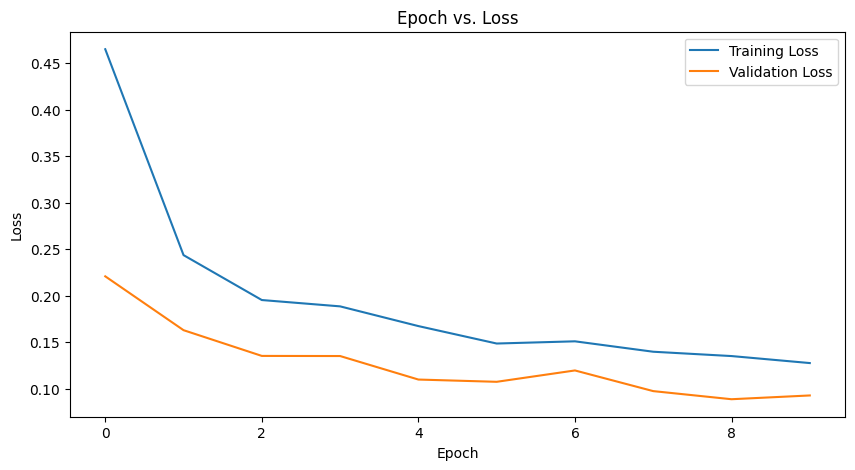

In [39]:
# Initialize model
resnet_weights = models.ResNet18_Weights.DEFAULT
base_model = models.resnet18(weights=resnet_weights)
resnet_transforms = resnet_weights.transforms()

# Modify classification layer
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, 3)  # 3 output classification

# Freeze weights of convolution layers
resnet_features = nn.Sequential(*(list(base_model.children())[0:8]))
for param in resnet_features.parameters():
    param.requires_grad = False

# Load the dataset
train_dataset = ImageFolder(root=train_dir, transform=resnet_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = ImageFolder(root=val_dir, transform=resnet_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

base_model = base_model.to(device)

base_model = train_model(base_model, train_loader, valid_loader, lr=0.001, num_epochs=10)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [28]:
 # Data loading and preprocessing for both training and validation datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(root=train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = ImageFolder(root=val_dir, transform=valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [31]:
 # Load the pre-trained MobileNetV2 model
mobile_model = models.mobilenet_v2(pretrained=True)

# Freeze the weights of the convolutional base
for param in mobile_model.features.parameters():
    param.requires_grad = False

# Modify the classifier for 3 classes: No Mask, Mask, and Mask Improper
mobile_model.classifier[1] = nn.Linear(mobile_model.last_channel, 3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.3398, Valid Loss: 0.1444
Epoch [2/10], Train Loss: 0.1893, Valid Loss: 0.1064
Epoch [3/10], Train Loss: 0.1596, Valid Loss: 0.0900
Epoch [4/10], Train Loss: 0.1488, Valid Loss: 0.0872
Epoch [5/10], Train Loss: 0.1366, Valid Loss: 0.0860
Epoch [6/10], Train Loss: 0.1313, Valid Loss: 0.0820
Epoch [7/10], Train Loss: 0.1336, Valid Loss: 0.0827
Epoch [8/10], Train Loss: 0.1262, Valid Loss: 0.0751
Epoch [9/10], Train Loss: 0.1106, Valid Loss: 0.0687
Epoch [10/10], Train Loss: 0.1098, Valid Loss: 0.0643


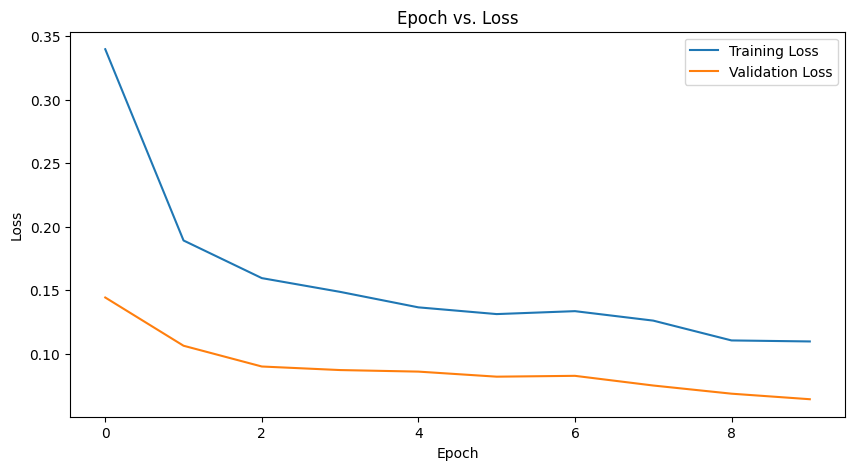

In [32]:
def train_model(model, train_loader, valid_loader, lr=0.001, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()  # Set model to evaluation mode
        total_valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()
        valid_losses.append(total_valid_loss / len(valid_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Epoch vs. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

# Call the function
trained_model = train_model(mobile_model, train_loader, valid_loader, lr=0.001, num_epochs=10)

Epoch 0 Finished.  Time per Epoch:  634.63 s 
Epoch 1 Finished.  Time per Epoch:  634.95 s 
Epoch 2 Finished.  Time per Epoch:  636.00 s 
Epoch 3 Finished.  Time per Epoch:  636.04 s 
Epoch 4 Finished.  Time per Epoch:  635.85 s 
Epoch 5 Finished.  Time per Epoch:  635.83 s 
Epoch 6 Finished.  Time per Epoch:  635.71 s 
Epoch 7 Finished.  Time per Epoch:  635.75 s 
Epoch 8 Finished.  Time per Epoch:  635.68 s 
Epoch 9 Finished.  Time per Epoch:  635.68 s 


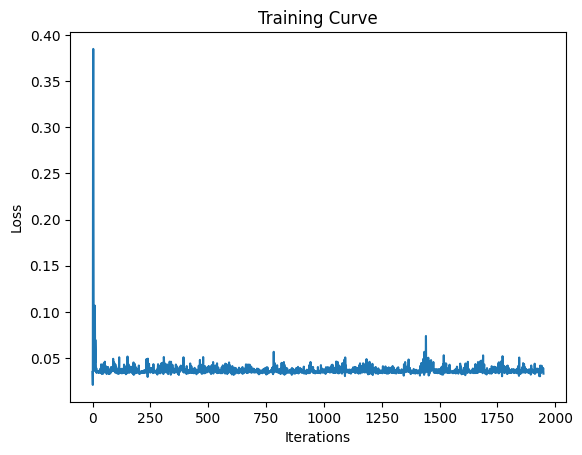

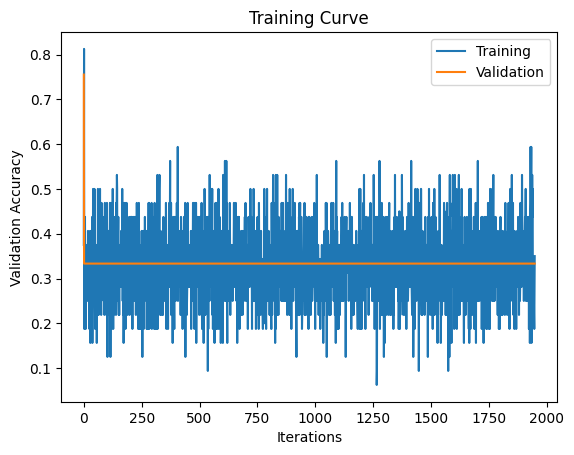

Final Training Accuracy: 0.3333333333333333
Final Validation Accuracy: 0.3333333333333333
Total time:   6356.79 s  Time per Epoch:  635.68 s 


In [25]:
train(mobilenet_model, train_data, val_data, 32, 10)